# Image Detection

In [ ]:
!pip install numpy scipy scikit-image matplotlib

In [2]:
import torch
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [3]:
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')
ssd_model.to('cuda')
ssd_model.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

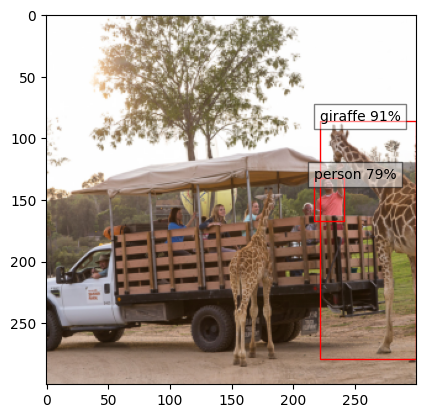

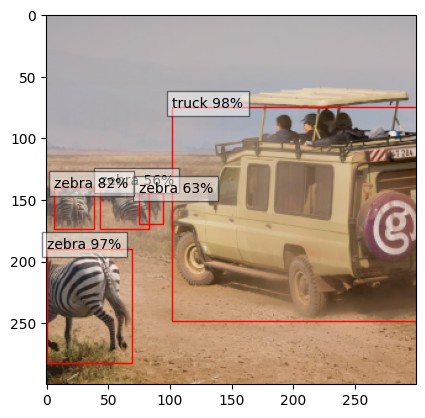

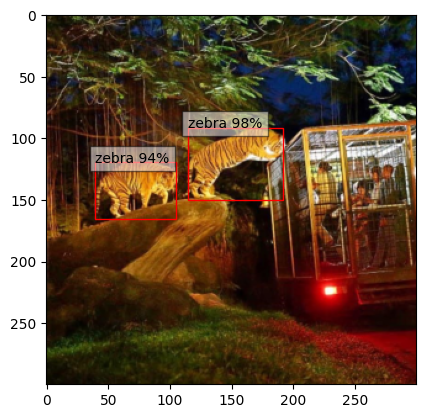

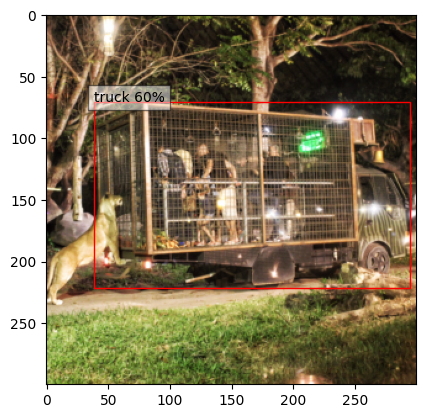

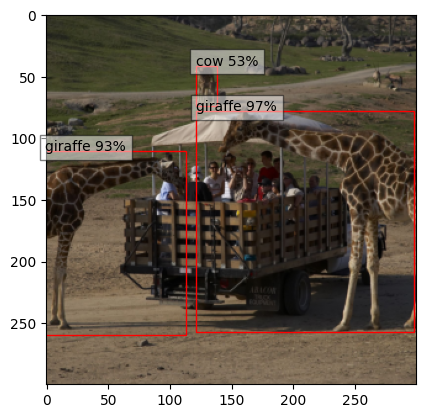

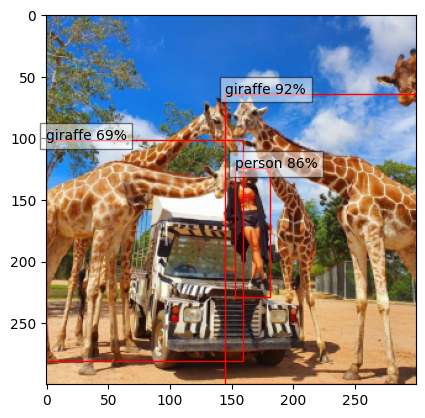

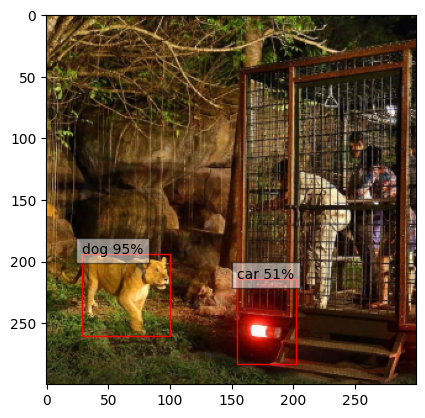

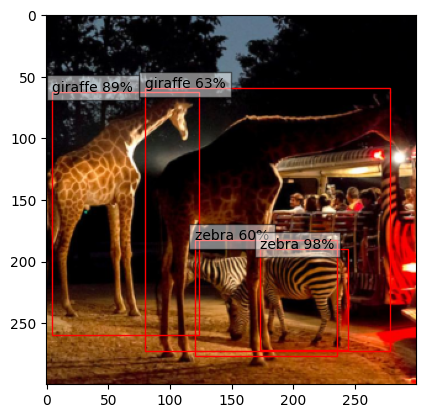

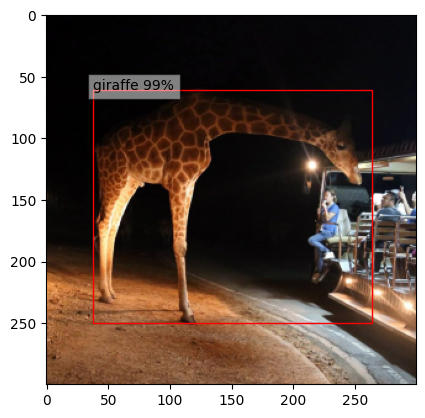

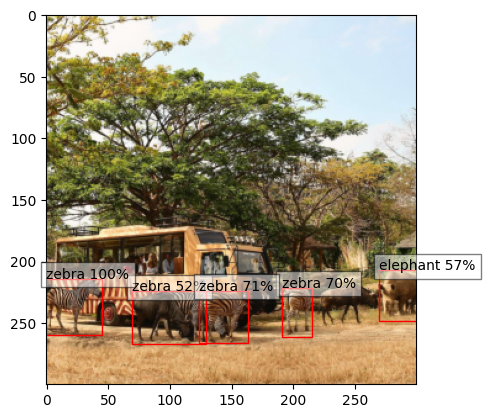

In [4]:
uris = [
    'images/image1.jpg',
    'images/image2.jpg',
    'images/image3.jpg',
    'images/image4.jpg',
    'images/image5.jpg',
    'images/image6.jpg',
    'images/image7.jpg',
    'images/image8.jpg',
    'images/image9.jpg',
    'images/image10.jpg'
]

# Подготовка входных данных
inputs = [utils.prepare_input(uri) for uri in uris]

# Подготовка тензора для модели
tensor = utils.prepare_tensor(inputs)

# Выполнение обнаружения объектов с использованием SSD-модели
with torch.no_grad():
  detections_batch = ssd_model(tensor)

# Декодирование результатов обнаружения
results_per_input = utils.decode_results(detections_batch)

# Выбор лучших результатов с пороговой уверенностью 0.50
best_results_per_input = [utils.pick_best(results, 0.50) for results in results_per_input]

# Получение словаря с соответствием классов меткам
classes_to_labels = utils.get_coco_object_dictionary()

# Итерация по изображениям с лучшими результатами
for image_idx in range(len(best_results_per_input)):
  # Создание графика для визуализации результатов
  fig, ax = plt.subplots(1)

  # Отображение оригинального изображения
  image = inputs[image_idx] / 2 + 0.5
  ax.imshow(image)

  # Отображение прямоугольников вокруг обнаруженных объектов и меток с уверенностью
  bboxes, classes, confidences = best_results_per_input[image_idx]
  for idx in range(len(bboxes)):
    left, bot, right, top = bboxes[idx]
    x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Вывод метки класса и уверенности
    ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx] * 100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# Video Detection

In [ ]:
import cv2
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import time

# Проверка, доступен ли GPU, и если да, то используем его
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загрузка предобученной SSD модели
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
model = model.to(device)
model.eval()

# Классы объектов (COCO dataset)
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant',
    'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A',
    'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Преобразование изображений для модели
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Путь к видеофайлу
video_path = 'video_1.mp4'  # Обновите этот путь в соответствии с вашим видеофайлом
cap = cv2.VideoCapture(video_path)

# Получение параметров видео для записи результата (если нужно)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS)) # количество кадров в секунду
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # 4-байтовый код, который используется для указания видеокодека
frame_number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # количество кадров в видео
#print('Number of frames in video:', frame_number)
# Сохранение видеофайла
out = cv2.VideoWriter('output_1_SSD.mp4', fourcc, fps, (width, height))


frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Преобразование кадра
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image = transform(image).unsqueeze(0)  # Преобразование и добавление батча

    # Применение модели
    with torch.no_grad():
        predictions = model(image)

    # Извлечение информации о детекциях
    pred_classes = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in predictions[0]['labels'].numpy()]
    pred_scores = predictions[0]['scores'].detach().numpy()
    pred_boxes = predictions[0]['boxes'].detach().numpy()

    # Визуализация детекций на кадре
    for i, (box, score, cls) in enumerate(zip(pred_boxes, pred_scores, pred_classes)):
        if score > 0.5:  # Порог уверенности
            startX, startY, endX, endY = box.astype(int)
            cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 0, 0), 2)
            label = f'{cls}: {score:.2f}'
            cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Запись кадра в выходное видео
    out.write(frame)

    #frame_count += 1
    #if frame_count % 30 == 0:  # Показывать каждый 30-й кадр
    #    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    #    plt.axis('off')
    #    plt.show()

# Освобождение ресурсов
cap.release()
out.release()
cv2.destroyAllWindows()

In [8]:
print('Number of frames in video 1:', frame_number)

Number of frames in video 1: 200


In [7]:
print('Number of frames in video 2:', frame_number)

Number of frames in video 2: 349
